<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Estimacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Conexion con google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ipywidgets as widgets
from IPython.display import display

Modelos escogidos para estimacion.

PCE - fold #1

Voc - fold #3

Jsc - fold #1

FF - fold #2

In [ ]:
#Cargamos los modelos para cada variable
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/'
with open(ruta_drive + 'trazados_estimacion.pkl', 'rb') as f:
    modelos = pickle.load(f)
with open(ruta_drive + 'transformaciones.pkl', 'rb') as f:
    transformaciones = pickle.load(f)
with open(ruta_drive + 'data_train_estimacion.pkl', 'rb') as f:
    data_train = pickle.load(f)

#Modelos


In [160]:
#Modelos escogidos
modelo_escogido = {
    "PCE": 1,
    "Voc": 3,
    "Jsc": 1,
    "FF": 2
}
modelo = {}
x_mean = {}
x_std = {}
y_mean = {}
y_std = {}
for var in modelo_escogido:
  modelo[var] = modelos[f"trace_{var}"][f"trace_fold{modelo_escogido[var]}"]["posterior"]
#Extraemos media y std
for var in modelo_escogido:
  x_mean[var] = data_train[f'data_train_{var}'][f'train_fold_{modelo_escogido[var]}']["x_mean"]
  x_std[var] = data_train[f'data_train_{var}'][f'train_fold_{modelo_escogido[var]}']["x_std"]
  y_mean[var] = data_train[f'data_train_{var}'][f'train_fold_{modelo_escogido[var]}']["y_mean"]
  y_std[var] = data_train[f'data_train_{var}'][f'train_fold_{modelo_escogido[var]}']["y_std"]

#Captura de datos de entrada

In [161]:
# Crear widgets para las variables
Ion_A = widgets.Text(description="A", layout=widgets.Layout(width='200px'))
Ion_B = widgets.Text(description="B", layout=widgets.Layout(width='200px'))
Ion_X = widgets.Text(description="X", layout=widgets.Layout(width='200px'))
Band_gap = widgets.Text(description="Band_gap", layout=widgets.Layout(width='200px'))
DeltaH = widgets.Text(description="DeltaH", layout=widgets.Layout(width='200px'))
DeltaL = widgets.Text(description="DeltaL", layout=widgets.Layout(width='200px'))
Grain_size= widgets.Text(description="Grain_size", layout=widgets.Layout(width='200px'))
Thickness = widgets.Text(description="Thickness", layout=widgets.Layout(width='200px'))

# Función para guardar los valores ingresados
def guardar_valores(_):
    global valores
    valores = {}
    variables = [Ion_A, Ion_B, Ion_X, Band_gap, DeltaH, DeltaL, Grain_size, Thickness]
    for var_widget in variables:
        var_nombre = var_widget.description
        var_valor = var_widget.value.strip()  # Eliminar espacios en blanco
        if not var_valor:
            print(f"Error: '{var_nombre}' es obligatorio.")
            return
        try:
            var_valor = float(var_valor)  # Intentar convertir a flotante
            valores[var_nombre] = var_valor
        except ValueError:
            print(f"Error: '{var_nombre}' debe ser un número válido.")
            return

    print("Valores guardados:", valores)

# Botón de guardar
boton_guardar = widgets.Button(description="Guardar")
boton_guardar.on_click(guardar_valores)

print("Unidades obligatorias para cada variable: [Ion_A : -], [Ion_B : -], [Ion_X : -], [Band gap : eV], [DeltaH : eV], [DeltaL : eV], [Grain size : mm], [Thickness : mm] \n")

# Crear una cuadrícula para organizar los widgets en filas y columnas
grid = widgets.GridspecLayout(2, 4)  # Dos filas y cuatro columnas

# Colocar las cajas de texto en la cuadrícula
grid[0, 0] = Ion_A
grid[0, 1] = Ion_B
grid[0, 2] = Ion_X
grid[0, 3] = Band_gap
grid[1, 0] = DeltaH
grid[1, 1] = DeltaL
grid[1, 2] = Grain_size
grid[1, 3] = Thickness

# Mostrar el formulario con las cajas de texto en horizontal
display(grid, boton_guardar)


Unidades obligatorias para cada variable: [Ion_A : -], [Ion_B : -], [Ion_X : -], [Band gap : eV], [DeltaH : eV], [DeltaL : eV], [Grain size : mm], [Thickness : mm] 



GridspecLayout(children=(Text(value='', description='A', layout=Layout(grid_area='widget001', width='200px')),…

Button(description='Guardar', style=ButtonStyle())

Valores guardados: {'A': 1.0, 'B': 1.0, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': 0.35}


#Prediccion dado los datos de entrada


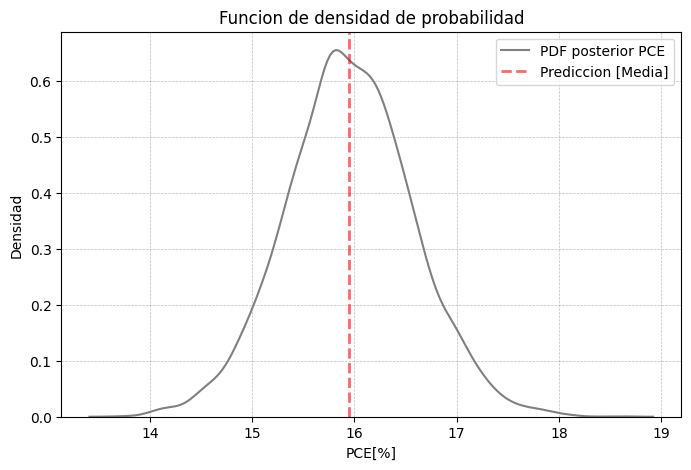

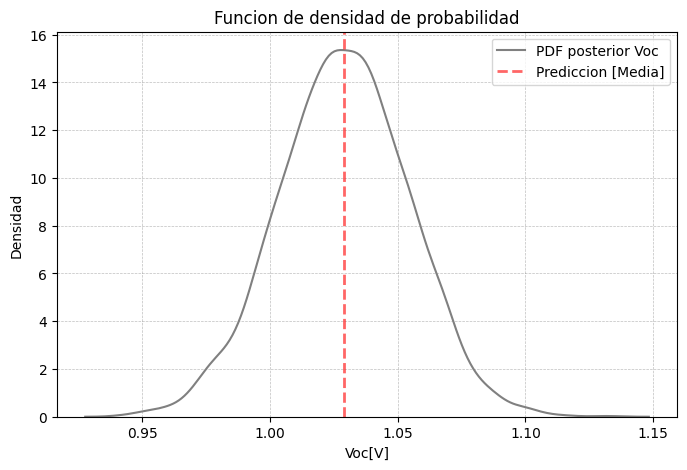

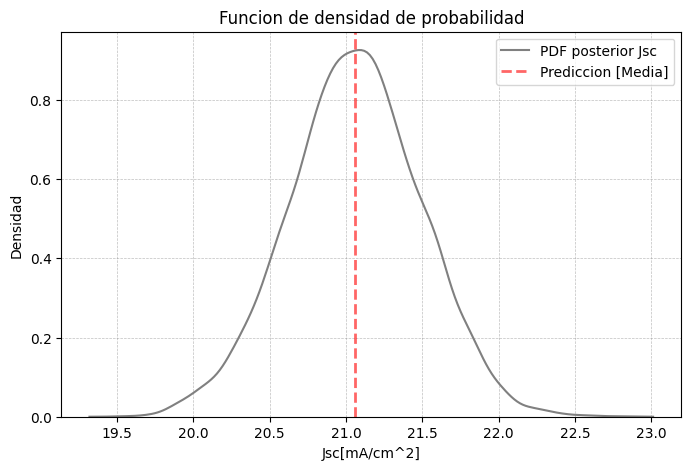

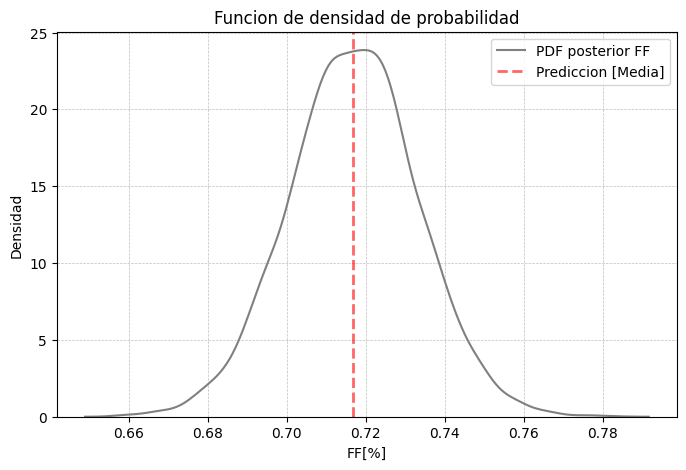

In [162]:
dict_transformaciones = dict(zip(["None", "log", "exp", "square", "sqrt"], [None, np.log, np.exp, np.square, np.sqrt])) #Diccionario de transformaciones
draws = 1000
chains = 5
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
unidades = {"Band_gap": "eV", "DeltaH": "eV", "DeltaL": "eV", "Grain_size": "mm", "Thickness": "mm", "PCE": "%", "Voc": "V", "Jsc": "mA/cm^2", "FF": "%"}
for var_modelo in modelo:
  entradas = []
  betas = []
  #Transfomaciones
  for var in valores:
    associated_transformation = dict_transformaciones[transformaciones[var_modelo][var]] #Se asocia la variable de entrada a una transformacion optima por variable.
    var_transformada = valores[var] if associated_transformation is None else associated_transformation(valores[var]) # Se realiza la transformacion.
    entradas.append(var_transformada)
    betas.append(np.concatenate(modelo[var_modelo][var]))
  #Estimaciones
  temp = entradas[1]
  entradas = (entradas-x_mean[var_modelo])/x_std[var_modelo]
  entradas[1] = temp
  alpha = modelo[var_modelo][f"{var_modelo}"]
  y_pred = (np.asarray(alpha).reshape((draws*chains)) + np.dot(entradas,np.asarray(betas)))
  y_pred = y_pred*(y_std[var_modelo]) + y_mean[var_modelo]
  mean = np.mean(y_pred, axis = 0)
  std = np.std(y_pred, axis = 0)
  plt.figure(figsize=(8, 5))
  posterior_predictive = sns.kdeplot(y_pred, label = f'PDF posterior {var_modelo}', color = "gray")
  # Calcular la media de la distribución de densidad posterior
  # Agregar línea vertical para la media de la distribución posterior
  plt.axvline(x=mean, color='r', linestyle='--', linewidth=2, label='Prediccion [Media]', alpha = 0.6)
  plt.xlabel(f"{var_modelo}[{unidades[var_modelo]}]")
  plt.ylabel("Densidad")
  plt.title("Funcion de densidad de probabilidad")
  plt.legend()
  plt.grid(True, **grid_style)
  plt.show()